In [61]:
import pandas as pd
from sklearn.svm import LinearSVC
from wordcloud import WordCloud,STOPWORDS

In [62]:
#df = pd.read_csv('Consumer_Complaints.csv')
df = pd.read_csv('14000_set.csv',encoding='latin1')
#df = df.sample(frac=0.10, random_state=99)
#df.head()

In [63]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [64]:
#df.info()

In [65]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [66]:
df.columns
df.columns = ['Product', 'Consumer_complaint_narrative']

In [67]:
ind_drop = df[df['Product'].apply(lambda x: x.startswith(('BMC issue' , 'Wallboard issue' , 'BMC issue' , 'Citrix issue' , 'Greenplum Issues' , 'IPCM Error' , 'IPCM error' , 'Missing Folder in MBNL' , 'Monolith panel error' , 'Network Protect Issues' , 'Other Issues' , 'Pegaplan error' , 'RAN request form' , 'Talend Issues' )))].index
df.drop(ind_drop, inplace=True)
df.loc[df['Product'].apply(lambda x: x.startswith(('Account Reset','Log in Issues' )))] = 'Account Locked'
df.loc[df['Product'].apply(lambda x: x.startswith(('Tool set access request','tool set access request', 'New account' )))] = 'New Account'

df.head()

,Product,Consumer_complaint_narrative
0,Account Locked,"Hi, Kindly unlock the mentioned IP..."
1,Account Locked,"Good Morning, Please see the update fro..."
2,Account Locked,Hi Can you please assist with this? ...
3,Account Locked,Hi team I can??t login to SIAE NMS ...
4,Account Locked,"Hi Team, Can you please reset my U20..."


In [68]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
print(id_to_category)

{0: 'Account Locked', 1: 'New Account', 2: 'Password Reset'}


In [69]:
from nltk.stem import WordNetLemmatizer
import re

stemmer = WordNetLemmatizer()

def cleanup(message):
    
    # Remove all the numbers
    document = re.sub("\d+", ' ', str(message))
    
    # Remove all the special characters
    document = re.sub('[^A-Za-z0-9]+', ' ', document)
    
    # remove all single characters
    for i in document.split():
        if len(i) == 1:
            document = document.replace(i , '')

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    return document


def remove_signature(message):
    string = " ".join(str(message).split())

    if 'Thank' in string:
        return(cleanup(string.split('Thank')[0]))
    elif 'thank' in string:
        return(cleanup(string.split('thank')[0]))
    elif 'Best Regard' in string:
        return(cleanup(string.split('Best Regard')[0]))
    elif 'Best regard' in string:
        return(cleanup(string.split('Best regard')[0]))
    elif 'Regard' in string:
        return(cleanup(string.split('Regard')[0]))
    elif 'regard' in string:
        return(cleanup(string.split('regard')[0]))
    elif 'BR' in string:
        return(cleanup(string.split('BR')[0]))
    else:
        return(cleanup(message))
    
df['Consumer_complaint_narrative'] = df['Consumer_complaint_narrative'].apply(remove_signature)

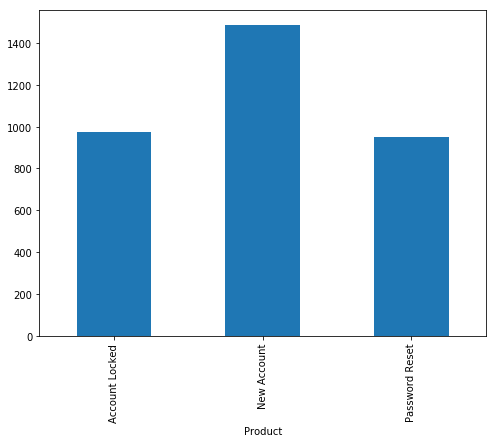

In [70]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [71]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(14, 14))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

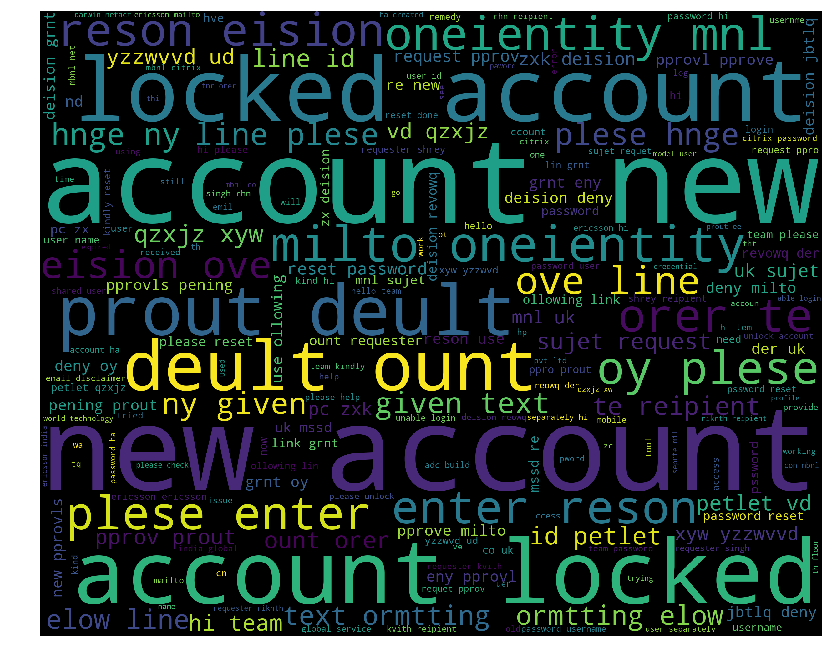

In [72]:
wordcloud_draw(df.Consumer_complaint_narrative)

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2),stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()


In [74]:
labels = df.category_id
features.shape

(3407, 1066)

In [75]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Account Locked':
  . Most correlated unigrams:
       . new
       . locked
  . Most correlated bigrams:
       . new account
       . account locked
# 'New Account':
  . Most correlated unigrams:
       . locked
       . new
  . Most correlated bigrams:
       . account locked
       . new account
# 'Password Reset':
  . Most correlated unigrams:
       . new
       . account
  . Most correlated bigrams:
       . account locked
       . new account


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [77]:
#print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

In [78]:
#print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

In [79]:
#df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

In [80]:
#df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\emueana\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\emueana\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\emueana\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\emueana\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:

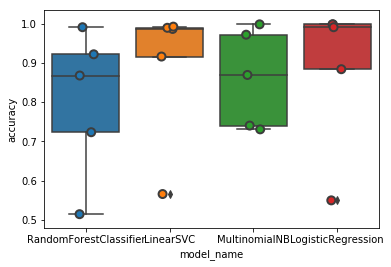

In [85]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [86]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.890315
LogisticRegression        0.884452
MultinomialNB             0.862297
RandomForestClassifier    0.803921
Name: accuracy, dtype: float64

In [87]:
from sklearn.model_selection import train_test_split

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=.6, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

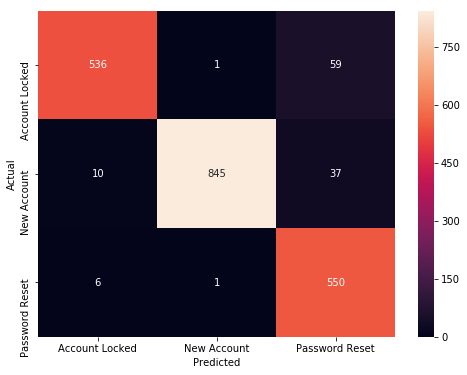

In [88]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [89]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'New Account' predicted as 'Account Locked' : 10 examples.


,Product,Consumer_complaint_narrative
1550,New Account,der uk mssd there re new pprovls pening prout ...
1564,New Account,hello nishn wih regrds o he bove itsm referenc...
1544,New Account,der uk mssd there re new pprovls pening prout ...
1545,New Account,der uk mssd there re new pprovls pening prout ...
1546,New Account,der uk mssd there re new pprovls pening prout ...
1543,New Account,der uk mssd there re new pprovls pening prout ...
1559,New Account,der uk mssd there re open pprovls pening prout...
1548,New Account,der uk mssd there re new pprovls pening prout ...
1549,New Account,der uk mssd there re new pprovls pening prout ...
1547,New Account,der uk mssd there re new pprovls pening prout ...



'Password Reset' predicted as 'Account Locked' : 6 examples.


,Product,Consumer_complaint_narrative
12093,Password Reset,hi please could you re set my password and unl...
12076,Password Reset,hi wa tried to change password for mbnl cag an...
11518,Password Reset,good vening am unable o login o he mbnl ool a ...
12073,Password Reset,hi have ried o rese i myself using ha link ear...
11758,Password Reset,hi surbhi have reated the password and updated...
11685,Password Reset,i donld we got confirmtion from elliot tht you...



'Account Locked' predicted as 'Password Reset' : 59 examples.


,Product,Consumer_complaint_narrative
14002,Account Locked,hi all my new id did not work please reset it
202,Account Locked,hi shrey don hve psscode opion is disbled see ...
14005,Account Locked,hi all wa having access to mbl account but now...
224,Account Locked,hi team my account is temporarily is locked ki...
14006,Account Locked,hi all why my credential is not working please...
4,Account Locked,hi team can you please reset my password a am ...
15,Account Locked,con mbnl recipient organisation only hi please...
252,Account Locked,hi used to hve ccess to adcbuild while bck but...
276,Account Locked,used an incorrect password too many time tryin...
156,Account Locked,good morning believe it is the mbnl remedy por...



'New Account' predicted as 'Password Reset' : 37 examples.


,Product,Consumer_complaint_narrative
1606,New Account,hi shailaj many
1640,New Account,morning cn you plese crete new user ccount for...
1576,New Account,hi aditya mbnl mssd have received my adcbuild ...
1630,New Account,hi ukmssd team please provide citrix id for be...
1609,New Account,hi tem cn you plese rise wo for below user cre...
1577,New Account,hi adity plee find ttched pm pprovl nd requet ...
1561,New Account,good morning please could an account be create...
1565,New Account,hello team the training for nec is already com...
1533,New Account,con mbnl recipient organisation only dear lorn...
1646,New Account,yes nortel credential only have shared


In [90]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [91]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  #print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Account Locked':
  . Top bigrams:
       . deult ount
       . prout deult
# 'New Account':
  . Top bigrams:
       . ha created
       . new account
# 'Password Reset':
  . Top bigrams:
       . reset password
       . password reset


In [92]:
'''texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")'''

'texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",\n         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",\n         "I can\'t get the money out of the country.",\n         "I have no money to pay my tuition",\n         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]\ntext_features = tfidf.transform(texts)\npredictions = model.predict(text_features)\nfor text, predicted in zip(texts, predictions):\n  print(\'"{}"\'.format(text))\n  print("  - Predicted as: \'{}\'".format(id_to_category[predicted]))\n  print("")'

In [93]:
texts = ["I have been trying to gain access to my MBNL Citrix account but it is locked. Can you let me know the process to unlock/ reapplyfor my account please.",
         "Could you please renew my MBNL Citrix Password?",
         "I unable to login T mobile by using user id mb1041790 while I am trying to login it show below error:",
         "Missing ATN950B Folder in the CORE Networking Scripts",
         "Please guide he how can I get access to Pegaplan and Asset"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I have been trying to gain access to my MBNL Citrix account but it is locked. Can you let me know the process to unlock/ reapplyfor my account please."
  - Predicted as: 'Account Locked'

"Could you please renew my MBNL Citrix Password?"
  - Predicted as: 'Password Reset'

"I unable to login T mobile by using user id mb1041790 while I am trying to login it show below error:"
  - Predicted as: 'Password Reset'

"Missing ATN950B Folder in the CORE Networking Scripts"
  - Predicted as: 'Password Reset'

"Please guide he how can I get access to Pegaplan and Asset"
  - Predicted as: 'Password Reset'



In [94]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                precision    recall  f1-score   support

Account Locked       0.97      0.90      0.93       596
   New Account       1.00      0.95      0.97       892
Password Reset       0.85      0.99      0.91       557

     micro avg       0.94      0.94      0.94      2045
     macro avg       0.94      0.94      0.94      2045
  weighted avg       0.95      0.94      0.95      2045



In [15]:
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english')) 
  
txt = "Please reset my password. " \
"please don't reset my password."
  
# sent_tokenize is one of instances of  
# PunktSentenceTokenizer from the nltk.tokenize.punkt module 
  
tokenized = sent_tokenize(txt) 
for i in tokenized: 
      
    # Word tokenizers is used to find the words  
    # and punctuation in a string 
    wordsList = nltk.word_tokenize(i) 
  
    # removing stop words from wordList 
    #wordsList = [w for w in wordsList if not w in stop_words]  
    #print(wordsList)
    #  Using a Tagger. Which is part-of-speech  
    # tagger or POS-tagger.  
    tagged = nltk.pos_tag(wordsList) 
  
    print(tagged) 

[('Please', 'NNP'), ('reset', 'VB'), ('my', 'PRP$'), ('password', 'NN'), ('.', '.')]
[('please', 'NN'), ('do', 'VBP'), ("n't", 'RB'), ('reset', 'VB'), ('my', 'PRP$'), ('password', 'NN'), ('.', '.')]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emueana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\emueana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [20]:
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

import re

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

expand_contractions('You don\'t need a library')


'You do not need a library'

In [18]:
def tag_words(sentence):
    import re
    # up to punctuation as in punct, put tags for words
    # following a negative word
    # find punctuation in the sentence
    punct = re.findall(r'[.:;!?]',sentence)[0]
    # create word set from sentence
    wordSet = { x for x in re.split("[.:;!?, ]",sentence) if x }
    keywordSet = {"don't","never", "nothing", "nowhere", "noone", "none", "not",
                  "hasn't","hadn't","can't","couldn't","shouldn't","won't",
                  "wouldn't","don't","doesn't","didn't","isn't","aren't","ain't"}
    # find negative words in sentence
    neg_words = wordSet & keywordSet
    if neg_words:
        for word in neg_words:
            start_to_w = sentence[:sentence.find(word)+len(word)]
            # put tags to words after the negative word
            w_to_punct =  re.sub(r'\b([A-Za-z\']+)\b',r'\1_NEG',
                               sentence[sentence.find(word)+len(word):sentence.find(punct)])
            punct_to_end = sentence[sentence.find(punct):]
            print(start_to_w + w_to_punct + punct_to_end)
    else:
        print("no negative words found ...")


s1 = "I don't want to go there: it might be dangerous"
tag_words(s1)
# I don't want_NEG to_NEG go_NEG there_NEG: it might be dangerous
s2 = "I want never to go there: it might be dangerous"
tag_words(s2)
# I want never to_NEG go_NEG there_NEG: it might be dangerous
s3 = "I couldn't to go there! it might be dangerous"
tag_words(s3)
# I couldn't to_NEG go_NEG there_NEG! it might be dangerous

I don't want_NEG to_NEG go_NEG there_NEG: it might be dangerous
I want never to_NEG go_NEG there_NEG: it might be dangerous
I couldn't to_NEG go_NEG there_NEG! it might be dangerous
